In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from scipy.io import loadmat
import time
from Adam import Adam
from utilities3 import *
# 检查CUDA是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")




Using device: cuda


In [2]:

# 加载数据
data = loadmat('../Data/NLSG.mat')
u = data['u']  # shape: (1500, 256, 100), 复值
x = data['x']  # shape: (1, 256)
t = data['t']  # shape: (1, 100)

# 转换为实部和虚部并移到GPU
u_real = torch.tensor(u.real, dtype=torch.float32).to(device)  # (1500, 256, 100)
u_imag = torch.tensor(u.imag, dtype=torch.float32).to(device)  # (1500, 256, 100)

n_train = 1000
n_test = 200

# 输入: u(x, t=0) —— 对所有空间点x，取第一个时间步t=0
train_input_real = u_real[:n_train, :, 0]  # (1000, 256)
train_input_imag = u_imag[:n_train, :, 0]  # (1000, 256)

# 目标: u(x, t>0) —— 对所有空间点x，取时间步t=1到t=99
train_target_real = u_real[:n_train, :, 1:]  # (1000, 256, 99)
train_target_imag = u_imag[:n_train, :, 1:]  # (1000, 256, 99)

# 测试集
test_input_real = u_real[-n_test:, :, 0]  # (200, 256)
test_input_imag = u_imag[-n_test:, :, 0]  # (200, 256)
test_target_real = u_real[-n_test:, :, 1:]  # (200, 256, 99)
test_target_imag = u_imag[-n_test:, :, 1:]  # (200, 256, 99)
# 展平目标并拼接实部虚部
train_target = torch.cat([
    train_target_real.reshape(n_train, -1),  # (1000, 256*99)
    train_target_imag.reshape(n_train, -1)  # (1000, 256*99)
], dim=1)  # (1000, 256*99*2)

test_target = torch.cat([
    test_target_real.reshape(n_test, -1),  # (200, 256*99)
    test_target_imag.reshape(n_test, -1)  # (200, 256*99)
], dim=1)  # (200, 256*99*2)



# 合并输入实部和虚部
train_input = torch.cat([train_input_real, train_input_imag], dim=1)  # (1000, 512)
test_input = torch.cat([test_input_real, test_input_imag], dim=1)  # (200, 512)

batch_size = 20
epochs = 500

print(train_input.shape,test_input.shape)


torch.Size([1000, 512]) torch.Size([200, 512])


In [3]:
class DeepONet_RealImag(nn.Module):
    def __init__(self, input_dim=256 * 2, output_dim=256 * 99 * 2, hidden_dim=512):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim))

    def forward(self, x):
        return self.net(x)


# 初始化模型并移到GPU



def relative_l2_loss(pred, target):
    num_examples = pred.size()[0]
    diff_norms = torch.norm(pred.reshape(num_examples,-1) - target.reshape(num_examples,-1), 2, 1)
    target_norms = torch.norm(target.reshape(num_examples,-1), 2, 1)
    return torch.sum(diff_norms/target_norms)  # 返回总损失，允许反向传播
 # 添加小常数防止除以0

In [5]:
model = DeepONet_RealImag().to(device)
learning_rate = 0.001
scheduler_step = 100
scheduler_gamma = 0.5
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)
TrainL_2 = []
TestL_2 = []
s_time = time.time()
for epoch in range(epochs):
    start_time = time.time()
    model.train()
    train_loss = 0.0

    # 随机打乱训练数据
    perm = torch.randperm(train_input.size(0), device=device)
    train_input = train_input[perm]
    train_target = train_target[perm]

    # Mini-batch训练
    for i in range(0, train_input.size(0), batch_size):
        batch_input = train_input[i:i + batch_size]
        batch_target = train_target[i:i + batch_size]

        optimizer.zero_grad()
        output = model(batch_input)
        loss = relative_l2_loss(output, batch_target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    scheduler.step()

    # 测试误差
    # 测试集损失
    # 测试集损失
    model.eval()  # 切换到评估模式
    test_loss = 0.0
    with torch.no_grad():  # 不计算梯度
        # 直接使用整个测试集
        output = model(test_input)
        loss = relative_l2_loss(output, test_target)
        test_loss = loss.item()  # 获取总的测试损失

    train_loss /= n_train
    test_loss /= n_test
    TrainL_2.append(train_loss)
    TestL_2.append(test_loss)
    # 输出每个 epoch 的训练损失和测试损失
    print(f"Epoch {epoch + 1}/{epochs}, "
          f"Train Loss: {train_loss :.6f}, "  # 除以训练数据样本总数
          f"Test Loss: {test_loss :.6f}, "  # 除以测试数据样本总数
          f"Time: {time.time() - start_time:.6f}s")

    
print(f"Total Time:{time.time() - s_time:.6f}s")

# 保存模型


Epoch 1/500, Train Loss: 0.317290, Test Loss: 0.126632, Time: 2.695072s
Epoch 2/500, Train Loss: 0.100380, Test Loss: 0.069396, Time: 0.399257s
Epoch 3/500, Train Loss: 0.072498, Test Loss: 0.060939, Time: 0.379131s
Epoch 4/500, Train Loss: 0.055031, Test Loss: 0.072503, Time: 0.376393s
Epoch 5/500, Train Loss: 0.051343, Test Loss: 0.038962, Time: 0.387595s
Epoch 6/500, Train Loss: 0.039189, Test Loss: 0.047422, Time: 0.385437s
Epoch 7/500, Train Loss: 0.039262, Test Loss: 0.051736, Time: 0.378342s
Epoch 8/500, Train Loss: 0.046965, Test Loss: 0.034394, Time: 0.388073s
Epoch 9/500, Train Loss: 0.045978, Test Loss: 0.035132, Time: 0.383547s
Epoch 10/500, Train Loss: 0.032335, Test Loss: 0.042214, Time: 0.381952s
Epoch 11/500, Train Loss: 0.042698, Test Loss: 0.038973, Time: 0.379732s
Epoch 12/500, Train Loss: 0.038319, Test Loss: 0.031973, Time: 0.385099s
Epoch 13/500, Train Loss: 0.031957, Test Loss: 0.044474, Time: 0.401061s
Epoch 14/500, Train Loss: 0.037996, Test Loss: 0.034147, Tim

Epoch 114/500, Train Loss: 0.007982, Test Loss: 0.009272, Time: 0.432414s
Epoch 115/500, Train Loss: 0.007891, Test Loss: 0.007460, Time: 0.435369s
Epoch 116/500, Train Loss: 0.008761, Test Loss: 0.015713, Time: 0.416908s
Epoch 117/500, Train Loss: 0.009622, Test Loss: 0.008647, Time: 0.443574s
Epoch 118/500, Train Loss: 0.008709, Test Loss: 0.008826, Time: 0.426771s
Epoch 119/500, Train Loss: 0.007098, Test Loss: 0.008848, Time: 0.430632s
Epoch 120/500, Train Loss: 0.007842, Test Loss: 0.007868, Time: 0.460546s
Epoch 121/500, Train Loss: 0.006391, Test Loss: 0.008300, Time: 0.485507s
Epoch 122/500, Train Loss: 0.007127, Test Loss: 0.007964, Time: 0.441393s
Epoch 123/500, Train Loss: 0.006554, Test Loss: 0.006959, Time: 0.440324s
Epoch 124/500, Train Loss: 0.008726, Test Loss: 0.008027, Time: 0.458128s
Epoch 125/500, Train Loss: 0.007030, Test Loss: 0.006219, Time: 0.492442s
Epoch 126/500, Train Loss: 0.007962, Test Loss: 0.009763, Time: 0.468347s
Epoch 127/500, Train Loss: 0.009345, T

Epoch 225/500, Train Loss: 0.003665, Test Loss: 0.004083, Time: 0.481580s
Epoch 226/500, Train Loss: 0.003826, Test Loss: 0.003173, Time: 0.504149s
Epoch 227/500, Train Loss: 0.004010, Test Loss: 0.003056, Time: 0.493188s
Epoch 228/500, Train Loss: 0.003248, Test Loss: 0.002759, Time: 0.482326s
Epoch 229/500, Train Loss: 0.003297, Test Loss: 0.003531, Time: 0.506492s
Epoch 230/500, Train Loss: 0.003738, Test Loss: 0.004169, Time: 0.490550s
Epoch 231/500, Train Loss: 0.003860, Test Loss: 0.003318, Time: 0.491154s
Epoch 232/500, Train Loss: 0.004944, Test Loss: 0.003946, Time: 0.496073s
Epoch 233/500, Train Loss: 0.004650, Test Loss: 0.003657, Time: 0.496970s
Epoch 234/500, Train Loss: 0.003733, Test Loss: 0.004050, Time: 0.490620s
Epoch 235/500, Train Loss: 0.004806, Test Loss: 0.004974, Time: 0.497339s
Epoch 236/500, Train Loss: 0.004358, Test Loss: 0.004140, Time: 0.482201s
Epoch 237/500, Train Loss: 0.003891, Test Loss: 0.003112, Time: 0.502519s
Epoch 238/500, Train Loss: 0.004105, T

Epoch 336/500, Train Loss: 0.002000, Test Loss: 0.002380, Time: 0.505754s
Epoch 337/500, Train Loss: 0.002107, Test Loss: 0.001784, Time: 0.492023s
Epoch 338/500, Train Loss: 0.002306, Test Loss: 0.001997, Time: 0.497055s
Epoch 339/500, Train Loss: 0.001987, Test Loss: 0.001542, Time: 0.497635s
Epoch 340/500, Train Loss: 0.001913, Test Loss: 0.002064, Time: 0.483686s
Epoch 341/500, Train Loss: 0.001761, Test Loss: 0.001933, Time: 0.497165s
Epoch 342/500, Train Loss: 0.001945, Test Loss: 0.002447, Time: 0.491080s
Epoch 343/500, Train Loss: 0.001915, Test Loss: 0.002144, Time: 0.496998s
Epoch 344/500, Train Loss: 0.002591, Test Loss: 0.003298, Time: 0.496780s
Epoch 345/500, Train Loss: 0.002358, Test Loss: 0.003011, Time: 0.497194s
Epoch 346/500, Train Loss: 0.002205, Test Loss: 0.001963, Time: 0.482225s
Epoch 347/500, Train Loss: 0.001986, Test Loss: 0.001765, Time: 0.497112s
Epoch 348/500, Train Loss: 0.002092, Test Loss: 0.001975, Time: 0.503736s
Epoch 349/500, Train Loss: 0.001877, T

Epoch 447/500, Train Loss: 0.001240, Test Loss: 0.001527, Time: 0.496739s
Epoch 448/500, Train Loss: 0.001300, Test Loss: 0.001171, Time: 0.491855s
Epoch 449/500, Train Loss: 0.001158, Test Loss: 0.001138, Time: 0.502599s
Epoch 450/500, Train Loss: 0.001162, Test Loss: 0.001259, Time: 0.491033s
Epoch 451/500, Train Loss: 0.001068, Test Loss: 0.001266, Time: 0.506821s
Epoch 452/500, Train Loss: 0.001201, Test Loss: 0.001142, Time: 0.489121s
Epoch 453/500, Train Loss: 0.001113, Test Loss: 0.001247, Time: 0.495687s
Epoch 454/500, Train Loss: 0.001115, Test Loss: 0.001184, Time: 0.495691s
Epoch 455/500, Train Loss: 0.001259, Test Loss: 0.001412, Time: 0.497053s
Epoch 456/500, Train Loss: 0.001406, Test Loss: 0.001239, Time: 0.496748s
Epoch 457/500, Train Loss: 0.001261, Test Loss: 0.001187, Time: 1.263905s
Epoch 458/500, Train Loss: 0.001206, Test Loss: 0.001127, Time: 0.492909s
Epoch 459/500, Train Loss: 0.001117, Test Loss: 0.001160, Time: 1.263876s
Epoch 460/500, Train Loss: 0.001160, T

In [6]:
# torch.save(model.state_dict(), 'model_deeponet.pth')

In [7]:
model = DeepONet_RealImag().to(device)
model.eval()  # 切换到评估模式
model.load_state_dict(torch.load('model_deeponet.pth'))
pred = torch.zeros(test_target.shape)
Pred_L2 = []
s_time = time.time()
with torch.no_grad():
    for i in range(test_input.size(0)):
        test_loss = 0
        start_time = time.time()
        output = model(test_input[i,:].unsqueeze(0))  # 单个样本输入
        pred[i] = output
        test_loss = relative_l2_loss(output, test_target[i,:].unsqueeze(0))
        Pred_L2.append(test_loss)
        print(f"第{i+1}个样本, Test Loss: {test_loss.item():.6f}, Time: {time.time() - start_time:.6f}s")
        
    print(f" Total Time: {time.time() - s_time:.6f}s")


第1个样本, Test Loss: 0.001498, Time: 0.022835s
第2个样本, Test Loss: 0.001106, Time: 0.009850s
第3个样本, Test Loss: 0.001004, Time: 0.008394s
第4个样本, Test Loss: 0.001537, Time: 0.006833s
第5个样本, Test Loss: 0.001525, Time: 0.000000s
第6个样本, Test Loss: 0.001198, Time: 0.015653s
第7个样本, Test Loss: 0.000986, Time: 0.000000s
第8个样本, Test Loss: 0.000957, Time: 0.015626s
第9个样本, Test Loss: 0.000774, Time: 0.000000s
第10个样本, Test Loss: 0.001230, Time: 0.015626s
第11个样本, Test Loss: 0.001726, Time: 0.000000s
第12个样本, Test Loss: 0.001046, Time: 0.015588s
第13个样本, Test Loss: 0.000902, Time: 0.015623s
第14个样本, Test Loss: 0.001308, Time: 0.000000s
第15个样本, Test Loss: 0.000824, Time: 0.015623s
第16个样本, Test Loss: 0.001069, Time: 0.000000s
第17个样本, Test Loss: 0.001982, Time: 0.015624s
第18个样本, Test Loss: 0.001303, Time: 0.000000s
第19个样本, Test Loss: 0.001202, Time: 0.015697s
第20个样本, Test Loss: 0.001376, Time: 0.000000s
第21个样本, Test Loss: 0.001411, Time: 0.015549s
第22个样本, Test Loss: 0.001063, Time: 0.000000s
第23个样本, Test Loss: 

In [8]:
output_reshaped = pred.view(n_test, 2, 256, 99).permute(0, 2, 3, 1)
test_target_reshaped = test_target.view(n_test, 2, 256, 99).permute(0, 2, 3, 1)
print(output_reshaped.shape,test_target_reshaped.shape)

torch.Size([200, 256, 99, 2]) torch.Size([200, 256, 99, 2])


In [9]:
def to_numpy_safe(x):
    if torch.is_tensor(x):
        return x.detach().cpu().numpy()
    elif isinstance(x, list):
        return [to_numpy_safe(i) for i in x]
    elif isinstance(x, dict):
        return {k: to_numpy_safe(v) for k, v in x.items()}
    else:
        return x  # already CPU float or numpy

scipy.io.savemat('NLSG_Deeponet.mat', {
    'pred_deeponet': to_numpy_safe(output_reshaped),
    'TrainL_2_deeponet': to_numpy_safe(TrainL_2),
    'TestL_2_deeponet': to_numpy_safe(TestL_2),
    'Pred_L2_deeponet': to_numpy_safe(Pred_L2),
})

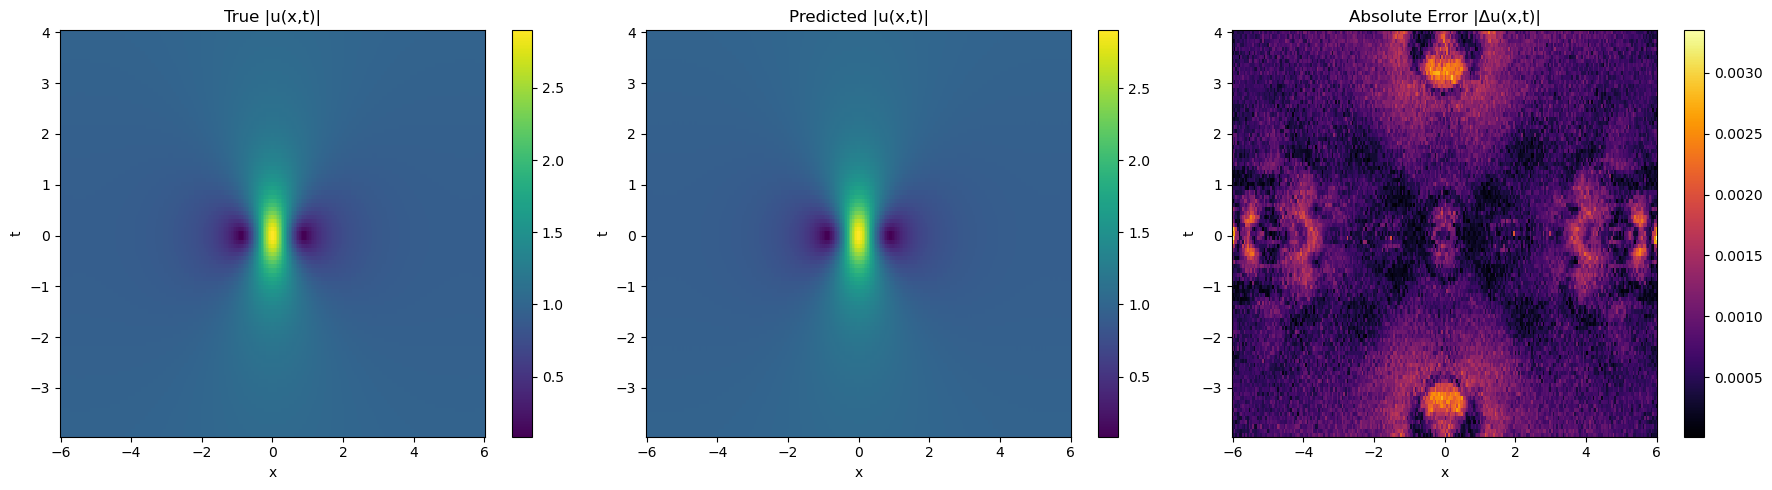

In [10]:
import matplotlib.pyplot as plt

# 随机选择一个样本
i = torch.randint(0, n_test, (1,)).item()

# 获取实部和虚部
pred_real = output_reshaped[i, :, :, 0].cpu().numpy()
pred_imag = output_reshaped[i, :, :, 1].cpu().numpy()
true_real = test_target_reshaped[i, :, :, 0].cpu().numpy()
true_imag = test_target_reshaped[i, :, :, 1].cpu().numpy()

# 幅值和误差
pred_abs = np.sqrt(pred_real**2 + pred_imag**2)
true_abs = np.sqrt(true_real**2 + true_imag**2)
abs_error = np.sqrt((pred_real - true_real)**2 + (pred_imag - true_imag)**2)

# 网格坐标
x_grid, t_grid = np.meshgrid(x.squeeze(), t.squeeze()[1:], indexing='ij')  # (256, 99)

# 绘图
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

im0 = axs[0].pcolormesh(x_grid, t_grid, true_abs, shading='auto', cmap='viridis')
axs[0].set_title("True |u(x,t)|")
plt.colorbar(im0, ax=axs[0])

im1 = axs[1].pcolormesh(x_grid, t_grid, pred_abs, shading='auto', cmap='viridis')
axs[1].set_title("Predicted |u(x,t)|")
plt.colorbar(im1, ax=axs[1])

im2 = axs[2].pcolormesh(x_grid, t_grid, abs_error, shading='auto', cmap='inferno')
axs[2].set_title("Absolute Error |Δu(x,t)|")
plt.colorbar(im2, ax=axs[2])

for ax in axs:
    ax.set_xlabel("x")
    ax.set_ylabel("t")

plt.tight_layout()
plt.show()
